## Building a Retrieval-Augmented Generation (RAG) System
#### Alan García Zermeño
06/11/2024

### Section 2: Setting up Retrieval System
#### This section includes:
- Code snippets for the retrieval system implementation.
- Examples of retrieval results for a few sample questions.
- An explanation of my choice and any trade-offs considered.

Lets import some libraries:
- NLTK for tokenize corpus and queries.
- rank_bm25 for the basic first step of retrieve relevant documents.
- Our script module for clean and load the database

In [1]:
import nltk
import google.generativeai as genai
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import sys
import os

# Import script modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../Scripts')))
from datacleaner import data_cleaner

[nltk_data] Downloading package punkt to /home/alan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


This is how we use our data loader and cleaner. This function returns the complete corpus, and two arrays with the Questions and Answers.

In [2]:
corpus,questions,answers = data_cleaner()
print(corpus[36])

49 Question/Answer pairs extracted!
Question: How did Keytruda perform in NSCLC patients with high PD-L1 expression in the KEYNOTE-051 trial?
   Answer: Keytruda showed significantly improved response rates and survival outcomes in NSCLC patients with high PD-L1 expression in the KEYNOTE-456 trial.


Since we will implement a complex CRAG system, we are going to use a very simple and lightweight library as a first naive approach to information retrieval given a query: rank_bm25. The get_top_n function is capable of rank the most relevant documents of a tokenized corpus given a tokenized query. In this case we print the 3 most relevant Q/A pairs given the query *Effects of Keytruda in treating cancer?*. 

In [3]:
doc_tokens = [word_tokenize(doc.lower()) for doc in corpus]
bm25 = BM25Okapi(doc_tokens)

In [4]:
query_tokens = word_tokenize("Does Keytruda work for all types of cancer?".lower())
top_docs = bm25.get_top_n(query_tokens, corpus,n=3)
for d in top_docs[:3]: print(d)

Question: Does Keytruda work for all types of cancer?:
 Answer: Keytruda is most effective in cancers that express PD-L1 and in a genetic background favorable to immune therapy.
Question: How does Keytruda work in combination with other therapies for NSCLC?:
 Answer:  Keytruda works synergistically with chemotherapy and other immunotherapies to enhance the immune response against cancer cells, often leading to improved outcomes.
Question: How long does it take to see the effects of Keytruda in treating cancer?:
 Answer: Some patients may see effects as early as 2 to 3 months into the treatment.


#### We are going to implement an adaptation of CRAG based on [Corrective Retrieval Augmented Generation paper](https://arxiv.org/abs/2401.15884)

The original system shows this structure:
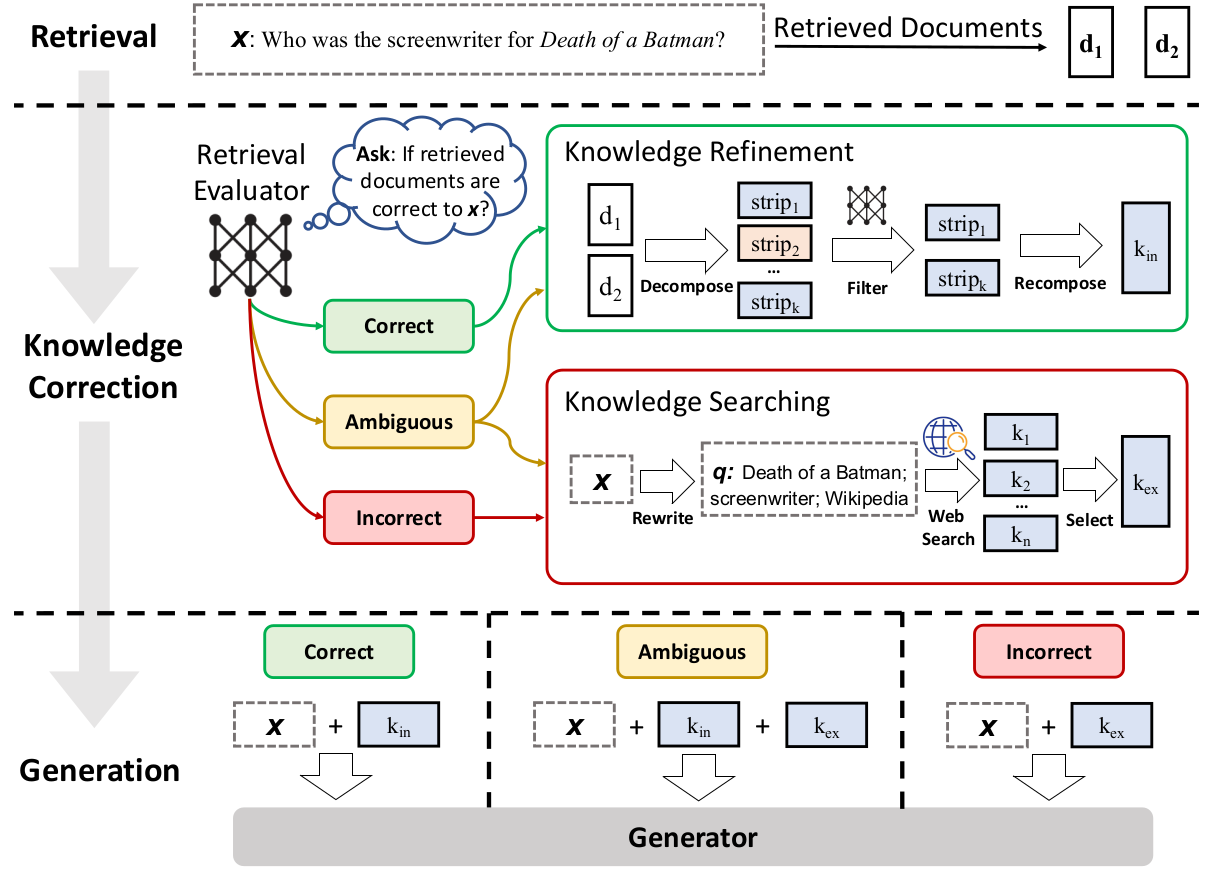

But we are going to make some fixes for make it even more flexible and light: 
- We will use BM250 as the basic retrieval.
- We will use the free Gemini API to use Gemini-pro Llm like a *corrector* model.
- Gemini will jugdge if the retrieved database answer is relevant to an input query.
- If not, we will perform web search for improving the document retrieval. (This will be implemented in section 6)

I chose to implement Corrective Retrieval Augmented Generation (CRAG) over the other techniques because is flexible ans suitable for varios aplications ans domains. In this case, I decide to adapt the CRAG to my hardware performance, adding a LLM to the evaluator for my retriever, I think this option is the best for a simple database like the provided given my hardware settings and working locally. Compared to the other techniques, CRAG integrates error correction, making it a superior choice for producing precise and reliable responses.

- Lets use Gemini-pro Llm as a corrective model. This is a powerfull model, free and easy for locally use.
- If we had more memory and hardware power we could download and use a HuggingFace model like Llama 2 instead of Gemini as a corrector.
- We will need an API key, you can get one in: https://ai.google.dev/gemini-api/docs/api-key.
- Then, save it in the 'Gemini.txt' file in the APIS directory. 
- **Please only paste the API key**.

In [5]:
with open("../APIS/Gemini.txt", 'r') as file: apiG = file.readline().strip()
genai.configure(api_key=apiG)
model = genai.GenerativeModel('gemini-pro')
safety= {'HARASSMENT':'block_none','HARM_CATEGORY_HATE_SPEECH':'block_none',
                  'HARM_CATEGORY_HARASSMENT':'block_none','HARM_CATEGORY_SEXUALLY_EXPLICIT':'block_none',
                  'HARM_CATEGORY_DANGEROUS_CONTENT':'block_none'}

We can get an answer per second in the Gemini-pro free version using *generate_content* function. Also, we can add an extra security layer with customized security settings.

In [6]:
prompt = "Effects of Keytruda in treating cancer?"
response = model.generate_content(prompt,safety_settings=safety)
print(response.text)

**Effects of Keytruda (Pembrolizumab) in Treating Cancer:**

Keytruda is a monoclonal antibody that blocks the PD-1 (programmed cell death protein 1) receptor on T cells. By blocking PD-1, Keytruda allows T cells to recognize and attack cancer cells.

**Positive Effects:**

* **Increased Antitumor Response:**
    * Keytruda enhances the ability of T cells to identify and kill cancer cells, leading to tumor regression and improved survival.
* **Durable Responses:**
    * Many patients experience long-term remissions or stable disease with Keytruda therapy.
* **Broad Spectrum Activity:**
    * Keytruda has shown efficacy in treating various types of solid tumors, including melanoma, lung cancer, bladder cancer, and head and neck cancer.
* **Checkpoint Blockade Mechanism:**
    * By inhibiting PD-1, Keytruda removes a barrier that cancer cells use to escape immune detection.
* **Immunotherapy:**
    * Keytruda harnesses the body's own immune system to fight cancer, offering potential for 

The *evaluator* function will be our retrieval system with the already specified settings. 

In [7]:
def evaluator(query,corpus,answers,safety = None):
    """ Evaluates whether the corpus is relevant to the query
    Args:
        query:      String query to evaluate
        corpus:     Documents array to search for information
        answers:    Answers array from the corpus without the questions
        safety:     Dic safety setting for Gemini generation
    """

    #Prompt instructions for evaluate the query-answer pair
    instructions = """Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    """

    #Extract the most relevant document using bm25
    query_tokens = word_tokenize(query.lower())
    top_docs = bm25.get_top_n(query_tokens, corpus, n=1)
    question = top_docs[0]                                  #Most relevant document
    indx = corpus.index(question)                           #Most relevant document index
    context = answers[indx]                                 #Most relevant answer

    #Final prompt for Gemini and Evaluation
    prompt = f"{instructions}\n\n\
        Question: {query}\n\n\
        Document: {context}\n\n\
        Evaluation: [Select one: Yes, No]:"
    response = model.generate_content(prompt,safety_settings=safety)

    print(prompt)
    print(response.text)
    return context if response.text == "Yes" else False

Lets test some examples. For each query test, we print the complete used prompt and the Gemini response. The Gemini task is to evaluate the retrieved response given a query. The evaluator should return the asnwer if its a clear answer for the query and bool variable False if is not.

In [8]:
evaluator("Keytruda purpose of the treatment",corpus,answers,safety)

Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: Keytruda purpose of the treatment

        Document: Approximately 40% of melanoma patients respond positively to Keytruda treatment.

        Evaluation: [Select one: Yes, No]:
No


False

In [9]:
evaluator("What is Keytruda?",corpus,answers,safety)

Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: What is Keytruda?

        Document: Keytruda is administered as an intravenous infusion over 30 minutes.

        Evaluation: [Select one: Yes, No]:
No


False

In [10]:
evaluator("How effective is Keytruda in treating non-small cell lung cancer?",corpus,answers,safety)

Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: How effective is Keytruda in treating non-small cell lung cancer?

        Document: Keytruda has shown to improve survival rates significantly in non-small cell lung cancer patients with PD-L1 expression.

        Evaluation: [Select one: Yes, No]:
Yes


'Keytruda has shown to improve survival rates significantly in non-small cell lung cancer patients with PD-L1 expression.'

In [40]:
evaluator("How long is the Keytruda treatment?",corpus,answers,safety)

Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: How long is the Keytruda treatment?

        Document: Some patients may see effects as early as 2 to 3 months into the treatment.

        Evaluation: [Select one: Yes, No]:
No


False

In [41]:
evaluator("How long does it take to see the effects of Keytruda in treating cancer?",corpus,answers,safety)

Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: How long does it take to see the effects of Keytruda in treating cancer?

        Document: Some patients may see effects as early as 2 to 3 months into the treatment.

        Evaluation: [Select one: Yes, No]:
Yes


'Some patients may see effects as early as 2 to 3 months into the treatment.'

#### For now, the system only returns the query answer if it is a response that is explicitly in the database, we will improve this in the next sections.